### BMI workflow

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [2]:
# define state
class BMIState(TypedDict):

    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [3]:
def calculate_bmi(state: BMIState) -> BMIState:

    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight/(height**2)

    state['bmi'] = round(bmi, 2)

    return state

In [4]:
def label_bmi(state: BMIState) -> BMIState:

    bmi = state['bmi']

    if bmi < 18.5:
        state["category"] = "Underweight"
    elif 18.5 <= bmi < 25:
        state["category"] = "Normal"
    elif 25 <= bmi < 30:
        state["category"] = "Overweight"
    else:
        state["category"] = "Obese"

    return state

In [5]:
# define your graph
graph = StateGraph(BMIState)

# add nodes to your graph
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node('label_bmi', label_bmi)

# add edges to your graph
graph.add_edge(START, 'calculate_bmi')
graph.add_edge('calculate_bmi', 'label_bmi')
graph.add_edge('label_bmi', END)


# compile the graph
workflow = graph.compile()

In [6]:
# execute the graph
intial_state = {'weight_kg':80, 'height_m':1.73}

final_state = workflow.invoke(intial_state)

print(final_state)

{'weight_kg': 80, 'height_m': 1.73, 'bmi': 26.73, 'category': 'Overweight'}


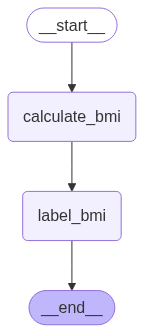

In [7]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

### Simple LLM workflow

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict
from dotenv import load_dotenv

In [9]:
load_dotenv()

True

In [10]:
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [11]:
# create a state

class LLMState(TypedDict):

    question: str
    answer: str

In [12]:
def llm_qa(state: LLMState) -> LLMState:

    # extract the question from state
    question = state['question']

    # form a prompt
    prompt = f'Answer the following question {question}'

    # ask that question to the LLM
    answer = model.invoke(prompt).content

    # update the answer in the state
    state['answer'] = answer

    return state

In [13]:
# create our graph

graph = StateGraph(LLMState)

# add nodes
graph.add_node('llm_qa', llm_qa)

# add edges
graph.add_edge(START, 'llm_qa')
graph.add_edge('llm_qa', END)

# compile
workflow = graph.compile()

In [14]:
# execute

intial_state = {'question': 'How far is moon from the earth?'}

final_state = workflow.invoke(intial_state)

print(final_state['answer'])

The distance between the Earth and the Moon isn't constant, as the Moon's orbit is an ellipse.

*   **Average distance:** 384,400 kilometers (238,900 miles)
*   **Closest point (perigee):** Around 363,104 kilometers (225,623 miles)
*   **Farthest point (apogee):** Around 405,696 kilometers (252,088 miles)


In [15]:
model.invoke('How far is moon from the earth?').content

"The distance between the Earth and the Moon varies because the Moon's orbit is an ellipse, not a perfect circle.\n\n*   **Average distance:** 384,400 kilometers (238,900 miles)\n*   **Closest point (perigee):** Around 363,104 kilometers (225,623 miles)\n*   **Farthest point (apogee):** Around 405,696 kilometers (252,088 miles)"

### Prompt chaining workflow

In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict
from dotenv import load_dotenv

In [4]:
load_dotenv()

model = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [5]:
class BlogState(TypedDict):

    title: str
    outline: str
    content: str

In [6]:
def create_outline(state: BlogState) -> BlogState:

    # fetch title
    title = state['title']

    # call llm gen outline
    prompt = f'Generate a detailed outline for a blog on the topic - {title}'
    outline = model.invoke(prompt).content

    # update state
    state['outline'] = outline

    return state

In [7]:
def create_blog(state: BlogState) -> BlogState:

    title = state['title']
    outline = state['outline']

    prompt = f'Write a detailed blog on the title - {title} using the follwing outline \n {outline}'

    content = model.invoke(prompt).content

    state['content'] = content

    return state

In [8]:
graph = StateGraph(BlogState)

# nodes
graph.add_node('create_outline', create_outline)
graph.add_node('create_blog', create_blog)

# edges
graph.add_edge(START, 'create_outline')
graph.add_edge('create_outline', 'create_blog')
graph.add_edge('create_blog', END)

workflow = graph.compile()

In [9]:
intial_state = {'title': 'Rise of AI in India'}

final_state = workflow.invoke(intial_state)

print(final_state)

{'title': 'Rise of AI in India', 'outline': '## Blog Outline: Rise of AI in India\n\n**I. Introduction (Hook & Overview)**\n\n*   **Hook:** Start with a compelling statistic or anecdote showcasing the growing influence of AI in India (e.g., projected AI market size, number of AI startups, impact on a specific industry).\n*   **Context:** Briefly introduce Artificial Intelligence (AI) and its broad definition.\n*   **Thesis Statement:** Clearly state the blog\'s purpose: To explore the rapid rise of AI in India, highlighting its drivers, key applications, challenges, and future prospects.\n*   **Roadmap:** Briefly outline the sections to be covered in the blog.\n\n**II.  Drivers of AI Growth in India**\n\n*   **A. Demographic Advantage:**\n    *   **Large Talent Pool:** Discuss India\'s large and growing pool of STEM graduates and skilled professionals.\n    *   **Young Population:** Highlight the inherent adaptability and willingness to embrace new technologies among the younger demogr

In [10]:
print(final_state['outline'])

## Blog Outline: Rise of AI in India

**I. Introduction (Hook & Overview)**

*   **Hook:** Start with a compelling statistic or anecdote showcasing the growing influence of AI in India (e.g., projected AI market size, number of AI startups, impact on a specific industry).
*   **Context:** Briefly introduce Artificial Intelligence (AI) and its broad definition.
*   **Thesis Statement:** Clearly state the blog's purpose: To explore the rapid rise of AI in India, highlighting its drivers, key applications, challenges, and future prospects.
*   **Roadmap:** Briefly outline the sections to be covered in the blog.

**II.  Drivers of AI Growth in India**

*   **A. Demographic Advantage:**
    *   **Large Talent Pool:** Discuss India's large and growing pool of STEM graduates and skilled professionals.
    *   **Young Population:** Highlight the inherent adaptability and willingness to embrace new technologies among the younger demographic.
    *   **Availability of Data:** Explain how India's

In [11]:
print(final_state['content'])

## Rise of AI in India: A Nation Poised to Lead the AI Revolution

**I. Introduction (Hook & Overview)**

*   **Hook:** By 2027, India's AI market is projected to reach a staggering $17 billion, a testament to the rapid adoption and transformative potential of Artificial Intelligence in the country. From revolutionizing healthcare to optimizing agriculture, AI is no longer a futuristic concept, but a present-day reality reshaping India's economic and social landscape.
*   **Context:** Artificial Intelligence (AI), in its simplest form, refers to the ability of machines to mimic human intelligence, performing tasks that typically require human intellect, such as learning, problem-solving, and decision-making.
*   **Thesis Statement:** This blog delves into the remarkable rise of AI in India, exploring the key drivers fueling its growth, highlighting its diverse applications across various sectors, examining the challenges it presents, and ultimately, painting a picture of its promising 